Sub task - 1: Unsupervised topic modeling
    
“Topic modeling is an unsupervised machine learning technique that’s capable of scanning a set of documents, detecting word and phrase patterns within them, and automatically clustering word groups and similar expressions that best characterize a set of documents.”

The first task at hand would be to churn out topic clusters based on the raw data provided. The more granular and closer the topic clusters are to the set of Provided Topics, the better.

You are free to go to any extent to refine the topic clusters to ensure that they are more aligned to the set of Provided Topics 

Example: 
If you have a phrase cluster like:
[great service, good garage service, professional service, friendly garage]

This above cluster is very relevant to the description of the topic:
garage service and this phrase/word cluster can be used to label all reviews containing any of these phrases as garage service.

## Prerequisites

In [1]:
#Importing Libraries

import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
nltk.download('stopwords')
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to C:\Users\Ruchit
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Modify the stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Discovering Dataset

In [3]:
#Read the Dataset
df = pd.read_csv(r'C:\Users\Ruchit Singh\Desktop\SentiSum NLP exercise\sentisum-assessment-dataset.csv',delimiter = '\t',quoting=3,encoding='ISO-8859-1')
df.head()

,Text
0,"""Tires where delivered to the garage of my cho..."
1,Very easy to use and good value for money.
2,Really easy and convenient to arrange
3,It was so easy to select tyre sizes and arrang...
4,service was excellent. Only slight downside wa...


## Data Cleaning and Preprocessing

In [4]:
data = df.Text.values.tolist()

#Remove the newline characters
data = [re.sub('\s+', ' ', sent) for sent in data]

#Remove the single quotes
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])

['"Tires where delivered to the garage of my choice,the garage notified me '
 'when they had been delivered. A day and time was arranged with the garage '
 'and I went and had them fitted,a Hassel free experience." Easy Tyre '
 'Selection Process, Competitive Pricing and Excellent Fitting Service"']


### Tokenisation and Cleaning text 

In [5]:
def s2w(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(s2w(data))

#print(data_words[:1])

### Building a Bigram and Trigram Model

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

### Remove Stopwords, Make Bigrams and Lemmatize

In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

###  Create the Dictionary and Corpus needed for Topic Modeling

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('arrange', 1),
  ('choice', 1),
  ('competitive', 1),
  ('day', 1),
  ('deliver', 2),
  ('excellent', 1),
  ('experience', 1),
  ('fitted', 1),
  ('fitting', 1),
  ('free', 1),
  ('garage', 3),
  ('go', 1),
  ('hassel', 1),
  ('notify', 1),
  ('pricing', 1),
  ('process', 1),
  ('selection', 1),
  ('service', 1),
  ('time', 1),
  ('tire', 1)]]

## Topic Modelling 

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.109*"easy" + 0.092*"quick" + 0.077*"customer" + 0.060*"process" + '
  '0.051*"simple" + 0.049*"cheap" + 0.032*"online" + 0.031*"come" + '
  '0.029*"way" + 0.027*"pick"'),
 (1,
  '0.218*"definitely" + 0.118*"fast" + 0.065*"future" + 0.052*"reliable" + '
  '0.050*"brand" + 0.045*"complaint" + 0.037*"many" + 0.033*"first_class" + '
  '0.030*"shop" + 0.018*"impressed"'),
 (2,
  '0.197*"service" + 0.179*"great" + 0.106*"price" + 0.099*"excellent" + '
  '0.037*"easy" + 0.035*"tyre" + 0.028*"thank" + 0.022*"competitive" + '
  '0.022*"website" + 0.021*"fitting"'),
 (3,
  '0.149*"value" + 0.139*"friendly" + 0.074*"service" + 0.071*"money" + '
  '0.063*"professional" + 0.052*"minute" + 0.024*"run" + 0.021*"agent" + '
  '0.019*"continue" + 0.017*"amazing"'),
 (4,
  '0.088*"problem" + 0.080*"arrive" + 0.076*"company" + 0.043*"even" + '
  '0.035*"wrong" + 0.026*"know" + 0.025*"leave" + 0.025*"last" + 0.022*"early" '
  '+ 0.022*"pressure"'),
 (5,
  '0.093*"redact" + 0.085*"tyre" + 0.080*"u

In [13]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4811468679154071


## Visualize the topics-keywords

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Ruchit Singh\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.264694  0.107276       1        1  19.659245
10    -0.260232 -0.009092       2        1  12.972050
5     -0.206876  0.090996       3        1  12.409945
2      0.017362 -0.290770       4        1  11.435138
6     -0.007566 -0.285510       5        1   9.874604
7      0.135510 -0.043374       6        1   9.508792
0      0.006120 -0.046994       7        1   7.112580
9     -0.045077  0.159953       8        1   6.777660
4      0.200230  0.199378       9        1   4.640564
3      0.229712 -0.055572      10        1   3.195358
1      0.195510  0.173709      11        1   2.414067, topic_info=     Category         Freq                Term        Total  loglift  logprob
21    Default  3603.000000                good  3603.000000  30.0000  30.0000
17    Default  4347.000000             service  4347.000000  29.0000  29.0000
42    Default  2252.000000               great  2252.000000  28.0000  28.0000
27    Default  3155.000000               price  3155.000000  27.0000  27.0000
223   Default  1287.000000               would  1287.000000  26.0000  26.0000
...       ...          ...                 ...          ...      ...      ...
2698  Topic11    16.741415  smooth_transaction    17.589212   3.6745  -5.0690
1604  Topic11    16.285923               bonus    17.133755   3.6731  -5.0965
863   Topic11     7.726665           inclusive     8.574480   3.6197  -5.8422
1016  Topic11     6.793950                 wet     7.641804   3.6063  -5.9708
1047  Topic11     3.517600           surprised     4.365399   3.5079  -6.6291

[444 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
308       1  0.228632        able
308       2  0.768204        able
921       5  0.987582  absolutely
509       5  0.986251      access
236      10  0.959776      actual
...     ...       ...         ...
340       8  0.982755        will
189       2  0.998033        work
223       6  0.999497       would
360       9  0.996841       wrong
323       3  0.995554        year

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 11, 6, 3, 7, 8, 1, 10, 5, 4, 2])

## Building LDA Mallet Model

In [17]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/Mallet/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:/Mallet/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

In [18]:
ldamallet = gensim.models.wrappers.LdaMallet(
   mallet_path, corpus=corpus, num_topics=12, id2word=id2word)
pprint(ldamallet.show_topics(formatted=False))

[(3,
  [('easy', 0.17877804430647665),
   ('quick', 0.10681529561168336),
   ('efficient', 0.08833074643713842),
   ('process', 0.06250881896430083),
   ('friendly', 0.06067447438972767),
   ('simple', 0.05686468181176803),
   ('helpful', 0.047692958938902213),
   ('staff', 0.04162551149992945),
   ('fast', 0.039650063496542966),
   ('order', 0.028926202906730633)]),
 (9,
  [('garage', 0.24155471501239076),
   ('tyre', 0.15860179992174253),
   ('order', 0.1197339246119734),
   ('local', 0.09064823268553542),
   ('fit', 0.07512716838398331),
   ('deliver', 0.035868005738880916),
   ('select', 0.03038998304421547),
   ('fitted', 0.018651362984218076),
   ('line', 0.016694926307551844),
   ('buying', 0.012129907395330639)]),
 (2,
  [('car', 0.07777250059368321),
   ('back', 0.029802897174067918),
   ('wheel', 0.023866065067679885),
   ('check', 0.01911659938256946),
   ('issue', 0.018404179529802896),
   ('hour', 0.018047969603419617),
   ('tire', 0.01721681310852529),
   ('leave', 0.0156

In [19]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4918417712988783


## Find the optimal number of topics for LDA

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

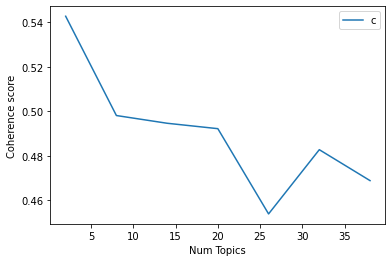

In [22]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5428
Num Topics = 8  has Coherence Value of 0.4981
Num Topics = 14  has Coherence Value of 0.4946
Num Topics = 20  has Coherence Value of 0.4922
Num Topics = 26  has Coherence Value of 0.4538
Num Topics = 32  has Coherence Value of 0.4827
Num Topics = 38  has Coherence Value of 0.4688


In [24]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.068*"day" + 0.068*"arrive" + 0.065*"wait" + 0.060*"appointment" + '
  '0.054*"car" + 0.051*"hour" + 0.047*"give" + 0.042*"turn" + 0.032*"minute" + '
  '0.026*"back"'),
 (1,
  '0.360*"easy" + 0.144*"quick" + 0.103*"process" + 0.094*"simple" + '
  '0.064*"convenient" + 0.027*"reliable" + 0.022*"ordering" + 0.019*"smoothly" '
  '+ 0.016*"straightforward" + 0.013*"smooth"'),
 (2,
  '0.159*"fitter" + 0.140*"redact" + 0.066*"issue" + 0.060*"customer" + '
  '0.036*"job" + 0.033*"provide" + 0.029*"deal" + 0.022*"bit" + 0.021*"tyre" + '
  '0.016*"mobile"'),
 (3,
  '0.492*"great" + 0.274*"service" + 0.163*"price" + 0.003*"fault" + '
  '0.003*"importantly" + 0.003*"tin" + 0.002*"round" + 0.002*"conveniently" + '
  '0.002*"competative" + 0.002*"requirement"'),
 (4,
  '0.475*"garage" + 0.168*"local" + 0.073*"deliver" + 0.072*"fit" + '
  '0.032*"fitted" + 0.020*"order" + 0.018*"perfect" + 0.013*"direct" + '
  '0.012*"line" + 0.010*"fitment"'),
 (5,
  '0.142*"tyre" + 0.118*"fit" + 0.100*"ti

## Finding the dominant topic in each sentence

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1134,"garage, local, deliver, fit, fitted, order, pe...","""Tires where delivered to the garage of my cho..."
1,1,6.0,0.0660,"tyre, redact, fit, money, arrange, save, year,...",Very easy to use and good value for money.
2,2,1.0,0.0702,"easy, quick, process, simple, convenient, reli...",Really easy and convenient to arrange
3,3,12.0,0.0789,"order, tyre, make, select, offer, wrong, pay, ...",It was so easy to select tyre sizes and arrang...
4,4,15.0,0.0731,"fitting, delivery, centre, purchase, date, loc...",service was excellent. Only slight downside wa...
5,5,7.0,0.0932,"efficient, friendly, service, helpful, staff, ...",User friendly Website. Competitive Prices. Goo...
6,6,13.0,0.0599,"good, price, competitive, selection, reasonabl...",Excellent prices and service
7,7,3.0,0.0686,"great, service, price, fault, importantly, tin...",It was very straightforward and the garage was...
8,8,4.0,0.0823,"garage, local, deliver, fit, fitted, order, pe...",Use of local garage.
9,9,10.0,0.0681,"good, price, quality, product, ease, locally, ...","""Easy to use, also good price."""


## Find the most representative document for each topic

In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2532,"day, arrive, wait, appointment, car, hour, giv...","""Ordering the tyres online and getting them de..."
1,1.0,0.1448,"easy, quick, process, simple, convenient, reli...","""Reliable cost effective way to buy tyres. Ive..."
2,2.0,0.2533,"fitter, redact, issue, customer, job, provide,...","""The company that only puts itself first never..."
3,3.0,0.1422,"great, service, price, fault, importantly, tin...","""Great Service. So easy, great prices, great s..."
4,4.0,0.1441,"garage, local, deliver, fit, fitted, order, pe...","""offered me dates and a garage which i accepte..."


## Topic distribution across documents

In [28]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"garage, local, deliver, fit, fitted, order, pe...",549.0,0.0542
1.0,6.0,"tyre, redact, fit, money, arrange, save, year,...",816.0,0.0805
2.0,1.0,"easy, quick, process, simple, convenient, reli...",372.0,0.0367
3.0,12.0,"order, tyre, make, select, offer, wrong, pay, ...",767.0,0.0757
4.0,15.0,"fitting, delivery, centre, purchase, date, loc...",429.0,0.0423
5.0,7.0,"efficient, friendly, service, helpful, staff, ...",391.0,0.0386
6.0,13.0,"good, price, competitive, selection, reasonabl...",303.0,0.0299
7.0,3.0,"great, service, price, fault, importantly, tin...",824.0,0.0813
8.0,4.0,"garage, local, deliver, fit, fitted, order, pe...",716.0,0.0707
9.0,10.0,"good, price, quality, product, ease, locally, ...",345.0,0.0341


## Save the labelled dataset

In [29]:
# Add the text column to the new dataset
df_dominant_topics['Text'] = df['Text']

In [30]:
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Text
0.0,4.0,"garage, local, deliver, fit, fitted, order, pe...",549.0,0.0542,"""Tires where delivered to the garage of my cho..."
1.0,6.0,"tyre, redact, fit, money, arrange, save, year,...",816.0,0.0805,Very easy to use and good value for money.
2.0,1.0,"easy, quick, process, simple, convenient, reli...",372.0,0.0367,Really easy and convenient to arrange
3.0,12.0,"order, tyre, make, select, offer, wrong, pay, ...",767.0,0.0757,It was so easy to select tyre sizes and arrang...
4.0,15.0,"fitting, delivery, centre, purchase, date, loc...",429.0,0.0423,service was excellent. Only slight downside wa...
5.0,7.0,"efficient, friendly, service, helpful, staff, ...",391.0,0.0386,User friendly Website. Competitive Prices. Goo...
6.0,13.0,"good, price, competitive, selection, reasonabl...",303.0,0.0299,Excellent prices and service
7.0,3.0,"great, service, price, fault, importantly, tin...",824.0,0.0813,It was very straightforward and the garage was...
8.0,4.0,"garage, local, deliver, fit, fitted, order, pe...",716.0,0.0707,Use of local garage.
9.0,10.0,"good, price, quality, product, ease, locally, ...",345.0,0.0341,"""Easy to use, also good price."""


In [31]:
df_dominant_topics.to_csv(r'C:\Users\Ruchit Singh\Desktop\SentiSum NLP exercise\Labelled dataset.csv')

In [32]:
dataset = pd.read_csv(r'C:\Users\Ruchit Singh\Desktop\SentiSum NLP exercise\Labelled dataset.csv')
dataset.head()

,Unnamed: 0,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Text
0,0.0,4.0,"garage, local, deliver, fit, fitted, order, pe...",549.0,0.0542,"""Tires where delivered to the garage of my cho..."
1,1.0,6.0,"tyre, redact, fit, money, arrange, save, year,...",816.0,0.0805,Very easy to use and good value for money.
2,2.0,1.0,"easy, quick, process, simple, convenient, reli...",372.0,0.0367,Really easy and convenient to arrange
3,3.0,12.0,"order, tyre, make, select, offer, wrong, pay, ...",767.0,0.0757,It was so easy to select tyre sizes and arrang...
4,4.0,15.0,"fitting, delivery, centre, purchase, date, loc...",429.0,0.0423,service was excellent. Only slight downside wa...
